In [1]:
import cv2
import ipympl
import numpy as np
np.random.seed(42)
import pandas as pd
import math
import scipy.io
import hdf5storage
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
#import matplotlib
#matplotlib.use('nbagg')
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean 
from sklearn.model_selection import train_test_split
from keras.callbacks.callbacks import EarlyStopping
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.python.keras.models import Model
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from keras import backend as K
import tensorflow as tf
import time

from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Average
from tensorflow.keras.models import Model
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from sklearn.metrics import classification_report
from keras.callbacks import TensorBoard
#indicate folder to save, plus other options
tensorboard = TensorBoard(log_dir='./logs/run', histogram_freq=0,
    write_graph=True, write_images=False)  
def sigmoid(X):
   return 1/(1+np.exp(-X))

Using TensorFlow backend.


In [2]:
iterations = 10
noise_amount = 1

sparse_g = False
sparsity_g = 1
kernel_g = 0
bias_g = 0
dropout_g = False
dropoutRate_g = 0.1
message = ""

simple = True
contracting = False
sparse = False
sparseDropout = False
denoising = False

if(simple):
    sparse_g = False
    sparsity_g = 1
    kernel_g = 0
    bias_g = 0
    dropout_g = False
    dropoutRate_g = 0.1
    message = "simple model"
elif(contracting):
    sparse_g = False
    sparsity_g = 1
    kernel_g = 0.01
    bias_g = 0.01
    dropout_g = False
    dropoutRate_g = 0.1
    message = "contracting model"
elif(sparse):
    sparse_g = True
    sparsity_g = 1
    kernel_g = 0
    bias_g = 0
    dropout_g = False
    dropoutRate_g = 0.1
    message = "sparse model"
elif(sparseDropout):
    sparse_g = True
    sparsity_g = 1
    kernel_g = 0
    bias_g = 0
    dropout_g = True
    dropoutRate_g = 0.1
    message = "sparseDropout model"
elif(denoising):
    sparse_g = False
    sparsity_g = 1
    kernel_g = 0
    bias_g = 0
    dropout_g = False
    dropoutRate_g = 0.1
    message = "denoising model"
                 

In [3]:
def Average2(lst): 
    return sum(lst) / len(lst) 

In [4]:
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [5]:
def createModel(inputs,table,kernel,bias,sparse,sparsity,dropout,dropoutRate,shape):
    for i in range(len(table)):
        if(i==0):
            if(sparse):
                if(dropout):
                    encoded = Dense(table[i], activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                     )(inputs)
                    encoded = Dropout(dropoutRate)(encoded)
                else:
                    encoded = Dense(table[i], activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                     )(inputs)
            elif(kernel==0):
                encoded = Dense(table[i], activation='relu')(inputs)
            else:
                encoded = Dense(table[i], activation='relu'
                    ,kernel_regularizer=l2(kernel) 
                    ,bias_regularizer=l2(bias)
                    )(inputs)
        elif(i==math.floor(len(table)/2)):
            if(sparse):
                if(dropout):
                    encoded = Dense(table[i], activation='relu'
                    ,activity_regularizer=regularizers.l1(sparsity)
                     )(encoded)
                    encoded = Dropout(dropoutRate)(encoded)
                else:
                    encoded = Dense(table[i], activation='relu'
                    ,activity_regularizer=regularizers.l1(sparsity)
                     )(encoded)
            elif(kernel==0):
                encoded = Dense(table[i], activation='relu')(encoded)
            else:
                encoded = Dense(table[i], activation='relu'
                    ,kernel_regularizer=l2(kernel) 
                    ,bias_regularizer=l2(bias)
                    )(encoded)    
        else:
            if(sparse):
                if(dropout):
                    encoded = Dense(table[i], activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                     )(encoded)
                    encoded = Dropout(dropoutRate)(encoded)
                else:
                    encoded = Dense(table[i], activation='relu'
                    #,activity_regularizer=regularizers.l1(sparsity)
                     )(encoded)
            elif(kernel==0):
                encoded = Dense(table[i], activation='relu')(encoded)
            else:
                encoded = Dense(table[i], activation='relu'
                    ,kernel_regularizer=l2(kernel) 
                    ,bias_regularizer=l2(bias)
                )(encoded)
    
    
    if(sparse):
        if(dropout):
            encodedL = Dense(shape, activation='tanh'
            #,activity_regularizer=regularizers.l1(sparsity)
                )(encoded)
            encodedL = Dropout(dropoutRate)(encodedL)
        else:
            encodedL = Dense(shape, activation='tanh'
            #,activity_regularizer=regularizers.l1(sparsity)
                )(encoded)
    elif(kernel==0):
        encodedL = Dense(shape, activation='tanh')(encoded)
    else:
        encodedL = Dense(shape, activation='tanh'
            ,kernel_regularizer=l2(kernel) 
            ,bias_regularizer=l2(bias)
            )(encoded)        
    model = Model(inputs, encodedL)
    model.compile(optimizer='adam', loss='mse')
    #model.summary()
    return model , encodedL
            

In [6]:
percentChosen = 0.01
#file_name = "cardio.mat"
#file_name = "ionosphere.mat"
#file_name = "satellite.mat"
#file_name = "shuttle.mat"
#file_name = "smtp.mat"
#file_name = "breastw.mat"
#file_name = "cover.mat"
#file_name = "mnist.mat"
#mat = hdf5storage.loadmat('smtp.mat')
file_name = "wine.mat"
#file_name = "arrhythmia.mat"
#file_name = "thyroid.mat"
mat = scipy.io.loadmat(file_name)
message = "best models percent = "+str(percentChosen)+" "+file_name   
epochs = 200
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=3)]
#callbacks = []
#callbacks = [EarlyStopping(monitor='val_loss', patience=1),tensorboard]
Xtemp = mat['X']
ytemp = mat['y']
X = np.array(Xtemp)
y = np.array(ytemp)
print(X.shape)
y = y.reshape(X.shape[0],)
print(y.shape)
outliers = 0
clean_data = []
contam_data = []

for i in range(y.shape[0]):
    if(y[i]==1.0):
        outliers+=1;
        contam_data.append(X[i])
    else:
        clean_data.append(X[i])
      

print("Total number of outliers in Dataset")        
print(outliers)
contam = outliers/y.shape[0]
print("Contamination in Dataset")
print(contam)
clean_data = np.array(clean_data)
contam_data = np.array(contam_data)
print(clean_data.shape)
clean_data2 = clean_data.copy()
contam_data2 = contam_data.copy()
# test_data_full = []
# for i in range(176):
#     test_data_full.append(contam_data[i])
# one = np.ones(176)
# test_data_full = np.array(test_data_full)

# test_data_full= np.append(test_data_full,one,1)

# print(test_data_full.shape)

Xy = X.copy()
Xy.shape
Xy = np.array(Xy)
Xy = np.insert(Xy, X.shape[1], y, axis=1)
#print(Xy.shape)
count = outliers
count2 = outliers


    
#selecting all the outliers from dataset
test_data =[]
for i in range(Xy.shape[0]):
    if(Xy[i,X.shape[1]]==1 and count>0):
        test_data.append(Xy[i])
        count = count-1
    
test_data = np.array(test_data)

#selecting random inliers from train data and removing them
indexes = np.random.choice(clean_data.shape[0], outliers, replace=False)

random_clean_data = clean_data[indexes, :]
random_clean_data = np.hstack((random_clean_data, np.zeros((random_clean_data.shape[0], 1), dtype=random_clean_data.dtype)))

indexes = indexes.reshape(outliers,1)

#deleting the values from train data
clean_data = np.delete(clean_data,indexes,0)
#print(clean_data)                
test_data = np.append(test_data,random_clean_data,axis=0)
np.random.shuffle(test_data)

print("test_data.shape")
print(test_data.shape)
#print(test_data.shape)
test_x = test_data[:,:test_data.shape[1]-1]
test_y = test_data[:,test_data.shape[1]-1]
#print(test_x.shape)
#print(test_y.shape)
test_x = pd.DataFrame(test_x)
test_y = pd.DataFrame(test_y)

print("train_data.shape")                    
print(clean_data.shape)    
X_train, X_test = train_test_split(clean_data2,  test_size=0.5)
X_test = np.append(X_test,np.zeros((X_test.shape[0],1),dtype='float64'),axis=1)

inliers_test = X_test.shape[0]

contam_new = contam_data2.shape[0]/X_test.shape[0]
contam_data3 = np.append(contam_data2,np.ones((contam_data2.shape[0],1),dtype='float64'),axis=1)
outliers_test = contam_data3.shape[0]
X_test = np.append(X_test,contam_data3,axis=0)
np.random.shuffle(X_test)
Xy_test = X_test.copy
y_test = X_test[:,X_test.shape[1]-1]
#print(y_test.shape)
X_test = np.delete(X_test,X_test.shape[1]-1,axis=1)
#print(X_test.shape)

X_test_np = X_test
y_test_np = y_test
print(y_test.shape)

X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
print("Number of Outliers in Test")
print(outliers_test)
print("Number of Inliers in Test")
print(inliers_test)
#print(X_train)
#print(X_train.mean())
#print(pd.DataFrame(X_train).describe())
X_train_noisy = X_train
#noisy data
#print(X_train_noisy)
def apply_noise(col):
    #print(col.mean())
    mu, sigma = 0, abs(col.mean())
    noise = np.random.normal(mu, sigma, col.shape[0]) 
    for i  in range(col.shape[0]):
        col[i] += noise_amount*noise[i]

    return col
#print(X_train)

scaler = MinMaxScaler(feature_range=(-1, 1))
clean_data = scaler.fit_transform(clean_data)
test_x  = scaler.transform(test_x)
clean_data = pd.DataFrame(clean_data)

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)
X_train_noisy = np.apply_along_axis(apply_noise, 0, X_train)
#clean_data = pd.DataFrame(clean_data)
#X_test.shape

(129, 13)
(129,)
Total number of outliers in Dataset
10
Contamination in Dataset
0.07751937984496124
(119, 13)
test_data.shape
(20, 14)
train_data.shape
(109, 13)
(70,)
Number of Outliers in Test
10
Number of Inliers in Test
60


In [7]:
#print(clean_data[1].mean())

In [8]:

for k in range(iterations): 
    
    
    tf.keras.backend.clear_session()
    start_time = time.time()
    models = []
    outs = []
    mses = []
    msesTrain = []
    aucs = []
    inputs = Input(shape=(X.shape[1],))
    
#     table = [5000,2000,1000,500,300,200,100,70,40,10,40,70,100,200,300,500,1000,2000,5000]

#     simpleAutoencoder7,simpleAutoencoder_out7 = createModel(inputs,table,kernel_g,bias_g,sparse_g,sparsity_g,dropout_g,dropoutRate_g,X.shape[1])
#     models.append(simpleAutoencoder7)
#     outs.append(simpleAutoencoder_out7)
    
#     table = [2000,1000,500,300,200,100,70,40,10,40,70,100,200,300,500,1000,2000]

#     simpleAutoencoder6,simpleAutoencoder_out6 = createModel(inputs,table,kernel_g,bias_g,sparse_g,sparsity_g,dropout_g,dropoutRate_g,X.shape[1])
#     models.append(simpleAutoencoder6)
#     outs.append(simpleAutoencoder_out6)
    
#     table = [500,300,200,100,70,40,10,40,70,100,200,300,500]

#     simpleAutoencoder5,simpleAutoencoder_out5 = createModel(inputs,table,kernel_g,bias_g,sparse_g,sparsity_g,dropout_g,dropoutRate_g,X.shape[1])
#     models.append(simpleAutoencoder5)
#     outs.append(simpleAutoencoder_out5)
    
#     table = [200,150,100,70,40,10,40,70,100,150,200]

#     simpleAutoencoder,simpleAutoencoder_out = createModel(inputs,table,kernel_g,bias_g,sparse_g,sparsity_g,dropout_g,dropoutRate_g,X.shape[1])
#     models.append(simpleAutoencoder)
#     outs.append(simpleAutoencoder_out)
    
#     table = [150,100,70,40,10,40,70,100,150]

#     simpleAutoencoder2,simpleAutoencoder_out2 = createModel(inputs,table,kernel_g,bias_g,sparse_g,sparsity_g,dropout_g,dropoutRate_g,X.shape[1])
#     models.append(simpleAutoencoder2)
#     outs.append(simpleAutoencoder_out2)

#     table = [100,70,40,10,40,70,100]

#     simpleAutoencoder3,simpleAutoencoder_out3 = createModel(inputs,table,kernel_g,bias_g,sparse_g,sparsity_g,dropout_g,dropoutRate_g,X.shape[1])
#     models.append(simpleAutoencoder3)
#     outs.append(simpleAutoencoder_out3)
    
#     table = [70,40,10,40,70]

#     simpleAutoencoder8,simpleAutoencoder_out8 = createModel(inputs,table,kernel_g,bias_g,sparse_g,sparsity_g,dropout_g,dropoutRate_g,X.shape[1])
#     models.append(simpleAutoencoder8)
#     outs.append(simpleAutoencoder_out8)
    
#     table = [40,10,40]

#     simpleAutoencoder4,simpleAutoencoder_out4 = createModel(inputs,table,kernel_g,bias_g,sparse_g,sparsity_g,dropout_g,dropoutRate_g,X.shape[1])
#     models.append(simpleAutoencoder4)
#     outs.append(simpleAutoencoder_out4)
    
    
#     #cardio best archs
    
    #simple model
    #table = [30,20,10,20,30]
    #table = [100,70,40,10,40,70,100]
    table = [2000,1000,500,300,200,100,70,40,10,40,70,100,200,300,500,1000,2000]
    #table = [5000,2000,1000,500,300,200,100,70,40,10,40,70,100,200,300,500,1000,2000,5000]
    simpleAutoencoder1,simpleAutoencoder_out1 = createModel(inputs,table,0,0,False,1,False,0.1,X.shape[1])
    models.append(simpleAutoencoder1)
    outs.append(simpleAutoencoder_out1)
    
    #contracting model


    simpleAutoencoder3,simpleAutoencoder_out3 = createModel(inputs,table,0.01,0.01,False,1,False,0.1,X.shape[1])
    models.append(simpleAutoencoder3)
    outs.append(simpleAutoencoder_out3)
    
    #sparse model
    simpleAutoencoder2,simpleAutoencoder_out2 = createModel(inputs,table,0,0,True,1,False,0.1,X.shape[1])
    models.append(simpleAutoencoder2)
    outs.append(simpleAutoencoder_out2)
    #sparse dropout model

    simpleAutoencoder6,simpleAutoencoder_out6 = createModel(inputs,table,0,0,True,1,True,0.1,X.shape[1])
    models.append(simpleAutoencoder6)
    outs.append(simpleAutoencoder_out6)
    #denoising model

    simpleAutoencoder7,simpleAutoencoder_out7 = createModel(inputs,table,kernel_g,bias_g,sparse_g,sparsity_g,dropout_g,dropoutRate_g,X.shape[1])
    models.append(simpleAutoencoder7)
    outs.append(simpleAutoencoder_out7)
    
    
#     #ion best archs
    
#     #simple model
#     table = [100,70,40,10,40,70,100]
#     simpleAutoencoder1,simpleAutoencoder_out1 = createModel(inputs,table,0,0,False,1,False,0.1,X.shape[1])
#     models.append(simpleAutoencoder1)
#     outs.append(simpleAutoencoder_out1)
    
#     #contracting model
#     table = [200,100,70,40,10,40,70,100,200]

#     simpleAutoencoder3,simpleAutoencoder_out3 = createModel(inputs,table,0.01,0.01,False,1,False,0.1,X.shape[1])
#     models.append(simpleAutoencoder3)
#     outs.append(simpleAutoencoder_out3)
    
#     #sparse model
#     table = [100,70,40,10,40,70,100]
    
#     simpleAutoencoder2,simpleAutoencoder_out2 = createModel(inputs,table,0,0,True,1,False,0.1,X.shape[1])
#     models.append(simpleAutoencoder2)
#     outs.append(simpleAutoencoder_out2)
#     #sparse dropout model
    
#     simpleAutoencoder6,simpleAutoencoder_out6 = createModel(inputs,table,0,0,True,1,True,0.1,X.shape[1])
#     models.append(simpleAutoencoder6)
#     outs.append(simpleAutoencoder_out6)
#     #denoising model
#     table = [200,100,70,40,10,40,70,100,200]

#     simpleAutoencoder7,simpleAutoencoder_out7 = createModel(inputs,table,kernel_g,bias_g,sparse_g,sparsity_g,dropout_g,dropoutRate_g,X.shape[1])
#     models.append(simpleAutoencoder7)
#     outs.append(simpleAutoencoder_out7)
    
    
#      #sat best archs
    
#     #simple model
#     table = [2000,1000,500,300,200,100,70,40,10,40,70,100,200,300,500,1000,2000]
#     simpleAutoencoder1,simpleAutoencoder_out1 = createModel(inputs,table,0,0,False,1,False,0.1,X.shape[1])
#     models.append(simpleAutoencoder1)
#     outs.append(simpleAutoencoder_out1)
    
#     #contracting model
    

#     simpleAutoencoder3,simpleAutoencoder_out3 = createModel(inputs,table,0.01,0.01,False,1,False,0.1,X.shape[1])
#     models.append(simpleAutoencoder3)
#     outs.append(simpleAutoencoder_out3)
    
#     #sparse model
    
    
#     simpleAutoencoder2,simpleAutoencoder_out2 = createModel(inputs,table,0,0,True,1,False,0.1,X.shape[1])
#     models.append(simpleAutoencoder2)
#     outs.append(simpleAutoencoder_out2)
#     #sparse dropout model
    
#     simpleAutoencoder6,simpleAutoencoder_out6 = createModel(inputs,table,0,0,True,1,True,0.1,X.shape[1])
#     models.append(simpleAutoencoder6)
#     outs.append(simpleAutoencoder_out6)
#     #denoising model
    

#     simpleAutoencoder7,simpleAutoencoder_out7 = createModel(inputs,table,0,0,False,1,False,0.1,X.shape[1])
#     models.append(simpleAutoencoder7)
#     outs.append(simpleAutoencoder_out7)
    
    

#     for i in range(len(models)):
#         if(denoising):
#             models[i].fit(X_train_noisy, X_train,
#                             epochs=epochs,
#                             batch_size=256,
#                             shuffle=True,
#                             callbacks=callbacks,
#                             validation_split=0.4,
#                             verbose=0
#                            )
#             decoded = models[i].predict(X_test)
#             mse = np.mean(np.power(X_test - decoded, 2), axis=1)
#             mse = mse.reshape(-1, 1)
#             scaler = MinMaxScaler(feature_range=(0, 1))
#             mse = scaler.fit_transform(mse)
#             mses.append(mse)
#         else:
#             models[i].fit(X_train, X_train,
#                             epochs=epochs,
#                             batch_size=256,
#                             shuffle=True,
#                             callbacks=callbacks,
#                             validation_split=0.4,
#                             verbose=0
#                            )
#             decoded = models[i].predict(X_test)
#             mse = np.mean(np.power(X_test - decoded, 2), axis=1)
#             mse = mse.reshape(-1, 1)
#             scaler = MinMaxScaler(feature_range=(0, 1))
#             mse = scaler.fit_transform(mse)
#             mses.append(mse)
            
            
    for i in range(len(models)):
        if(i<(len(models)-1)):
            models[i].fit(X_train, X_train,
                            epochs=epochs,
                            batch_size=256,
                            shuffle=True,
                            callbacks=callbacks,
                            validation_split=0.3,
                            verbose=0
                           )
            
            decoded = models[i].predict(X_test)
            decodedTrain = models[i].predict(X_train)
            mseTrain = np.mean(np.power(X_train - decodedTrain, 2), axis=1)
            mseTrain = mseTrain.reshape(-1, 1)
            scaler = MinMaxScaler(feature_range=(0, 1))
            #mseTrain = scaler.fit_transform(mseTrain)
            msesTrain.append(mseTrain)
            
            mse = np.mean(np.power(X_test - decoded, 2), axis=1)
            #mse = mse.values.reshape(-1, 1)
            mse = mse.reshape(-1, 1)
            scaler = MinMaxScaler(feature_range=(0, 1))
            #mse = scaler.fit_transform(mse)
            mses.append(mse)
        else:
            models[i].fit(X_train_noisy, X_train,
                            epochs=epochs,
                            batch_size=256,
                            shuffle=True,
                            callbacks=callbacks,
                            validation_split=0.3,
                            verbose=0
                           )
            
            decoded = models[i].predict(X_test)
            mse = np.mean(np.power(X_test - decoded, 2), axis=1)
            #mse = mse.values.reshape(-1, 1)
            mse = mse.reshape(-1, 1)
            scaler = MinMaxScaler(feature_range=(0, 1))
            #mse = scaler.fit_transform(mse)
            mses.append(mse)
            decodedTrain = models[i].predict(X_train_noisy)
            mseTrain = np.mean(np.power(X_train_noisy - decodedTrain, 2), axis=1)
            mseTrain = mseTrain.reshape(-1, 1)
            #mseTrain = scaler.fit_transform(mseTrain)
            msesTrain.append(mseTrain)
        
    
    temp = np.array(mses)
    ensemble = (np.sum(temp,axis = 0)/(len(mses)))
    #print(ensemble)
    mses.append(ensemble)
    
    
  
    #x = concatenate([decoded3_de2, decoded3_s3,decoded3,decoded3_s2])  # merge the outputs of the two models
    x = Average()(outs) 

    out = Dense(X.shape[1],activation='tanh'
                #, kernel_regularizer=l2(kernel_reg) 
                #, bias_regularizer=l2(bias_reg)
               )(x)  # final layer of the network
    Emodel = Model(inputs=inputs, outputs=out)
    for l in Emodel.layers:
        l.trainable = False

    Emodel.layers[len(Emodel.layers)-1].trainable = True

    Emodel.compile(optimizer='adam', loss='mse')
    Emodel.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=256,
                    shuffle=True,
                    callbacks=callbacks,
                    validation_split=0.4,
                    verbose=0
    )

    ensemble_pred = Emodel.predict(X_test)
    #print(ensemble_pred)
    ensemble2_mse = np.mean(np.power(X_test - ensemble_pred, 2), axis=1)
    #ensemble2_mse = ensemble2_mse.values.reshape(-1, 1)
    ensemble2_mse = ensemble2_mse.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    #ensemble2_mse = scaler.fit_transform(ensemble2_mse)
    #print(ensemble2_mse)
    mses.append(ensemble2_mse)
    decodedTrain = Emodel.predict(X_train)
    mseTrain = np.mean(np.power(X_train - decodedTrain, 2), axis=1)
    mseTrain = mseTrain.reshape(-1, 1)
    #mseTrain = scaler.fit_transform(mseTrain)
    msesTrain.append(mseTrain)
    
    for i in range(len(mses)):
        
        fpr_keras3, tpr_keras3, thresholds_keras3 = roc_curve(y_test, mses[i])
        auc_keras3 = auc(fpr_keras3, tpr_keras3)
        aucs.append(auc_keras3)
        #plt.figure(1)
        #plt.plot([0, 1], [0, 1], 'k--')

        #plt.plot(fpr_keras3, tpr_keras3, label='Keras (area = {:.3f})'.format(auc_keras3))
        #print(auc_keras3)
    #plt.xlabel('False positive rate')
    #plt.ylabel('True positive rate')
    #plt.title('ROC curve')
    #plt.legend(loc='best')
    #plt.show()    
    
    print('results')
    
    #3% tha thewrw lathos apo ta swsta -> predict apo ta training dedomena gia na vgei to threshold
#     votes = [];
#     threshes = [];
#     for i in range(len(mses)):
#         threshes.append(Find_Optimal_Cutoff(y_test,mses[i]))
#     for i in range(len(threshes)):
#         temp = mses[i]
#         tempvotes = []
#         for j in range(len(y_test)):
#             if(temp[j]>threshes[i]):
#                 tempvotes.append(1)
#             else:
#                 tempvotes.append(0)
#         votes.append(tempvotes)
    y_test_list = y_test.values.tolist()

#     results_with_thresh = []
#     for j in range(len(threshes)):    
#         sumss = 0;
#         for i in range(len(y_test_list)):
#             if(votes[j][i]==y_test_list[i][0]):
#                 sumss = sumss+1
#         #print(str(vote_result[i])+'\t '+ str(y_test_list[i]))  
#         results_with_thresh.append(sumss/len(y_test_list));
#         #print(sumss/len(y_test_list))
    
#     vote_result = []
#     for i in range(len(y_test_list)):
#         if((votes[0][i]+votes[1][i]+votes[2][i]+votes[3][i]+votes[4][i])/5>=0.5):
#             vote_result.append(1)
#         else:
#             vote_result.append(0)

#     sumss = 0;
#     for i in range(len(y_test_list)):
#         if(vote_result[i]==y_test_list[i][0]):
#             sumss = sumss+1
#         #print(str(vote_result[i])+'\t '+ str(y_test_list[i]))        
#     results_with_thresh.append(sumss/len(y_test_list))
    #print("results_with_thresh",sumss/len(y_test_list))

   
           
    


    maxThres = 0;
#     for i in range(len(mses)):
#         scaler = MinMaxScaler(feature_range=(0, 1))
#         mses[i] = scaler.fit_transform(mses[i])
#     for i in range(len(msesTrain)):
#         scaler = MinMaxScaler(feature_range=(0, 1))
#         msesTrain[i] = scaler.fit_transform(msesTrain[i])

    threshez = []
    for i in range(len(msesTrain)):
        threshez.append(-np.sort(-msesTrain[i],axis =0)[math.ceil((msesTrain[0].shape[0])*percentChosen)][0])    
    
#     votes = [];
#     threshes = [];

#     for i in range(len(mses)):
#         threshes.append(Find_Optimal_Cutoff(y_test,mses[i]))
#     for i in range(len(threshes)):
#         temp = mses[i]
#         tempvotes = []
#         for j in range(len(y_test)):
#             if(temp[j]>threshes[i]):
#                 tempvotes.append(1)
#             else:
#                 tempvotes.append(0)
#         votes.append(tempvotes)
#     votes = np.array(votes)

#     performanceSingle = []
#     y_test_list = y_test.values.tolist()
#     for j in range(len(threshes)):    
#         sumss = 0;
#         for i in range(len(y_test_list)):
#             if(votes[j][i]==y_test_list[i][0]):
#                 sumss = sumss+1
#         performanceSingle.append(sumss/len(y_test_list))
    
    
    votes = [];
    #votes_negative = [];
    
    for i in range(len(threshez)):
        temp = mses[i]
        tempvotes = []
        for j in range(len(y_test)):
            if(mses[i][j]>threshez[i] ):
                tempvotes.append(1)
            else:
                tempvotes.append(0)
        votes.append(tempvotes)
    votes = np.array(votes)

    performanceIndividual = []
    for j in range(len(threshez)):    
        sumss = 0;
        for i in range(len(y_test_list)):
            if(votes[j][i]==y_test_list[i][0]):
                sumss = sumss+1
        performanceIndividual.append(sumss/len(y_test_list))
    
    
    print("performanceIndividual",performanceIndividual)
         
    distances_from_thresh = []
    for i in range(len(threshez)):
        temp = mses[i]
        tempdistances = []
        for j in range(len(msesTrain[0])):
            tempdistances.append(msesTrain[i][j][0]-threshez[i])
        distances_from_thresh.append(tempdistances)
    #print(distances_from_thresh)
    distances_from_thresh = np.array(distances_from_thresh)
    distances_from_thresh = np.tanh(distances_from_thresh)
#     for i in range(len(distances_from_thresh)):
#         distances_from_thresh[i] = (distances_from_thresh[i] - np.min(distances_from_thresh[i])/np.ptp(distances_from_thresh[i]))

    distance_from_thresh_0 = distances_from_thresh[0].mean()
    #print(distances_from_thresh[1].mean())
    distance_from_thresh_1 = distances_from_thresh[1].mean()
    #print(distances_from_thresh[2].mean())
    distance_from_thresh_2 = distances_from_thresh[2].mean()
    #print(distances_from_thresh[3].mean())
    distance_from_thresh_3 = distances_from_thresh[3].mean()
    #print(distances_from_thresh[4].mean())
    distance_from_thresh_4 = distances_from_thresh[4].mean()
    #print(distances_from_thresh[5].mean())
    distance_from_thresh_5 = distances_from_thresh[5].mean()
    #print("values")
    mean_of_means = np.mean([distances_from_thresh[0].mean(),distances_from_thresh[1].mean(),distances_from_thresh[2].mean(),distances_from_thresh[3].mean(),distances_from_thresh[4].mean(),distances_from_thresh[5].mean()])
    #print("mean_of_means")


    ttt = []
    for i in range(len(distances_from_thresh[0])):
        ttt.append((distances_from_thresh[0][i]+distances_from_thresh[1][i]+distances_from_thresh[2][i]+distances_from_thresh[3][i]+distances_from_thresh[4][i]+distances_from_thresh[5][i])/6)
    #plt.plot(distances_from_thresh[1],color="blue")
    #plt.plot(distances_from_thresh[1],color="red")
    #plt.plot(distances_from_thresh[0])
    #plt.plot(distances_from_thresh[2])

    #plt.plot(distances_from_thresh[3])
    #plt.plot(distances_from_thresh[4])
    #plt.plot(distances_from_thresh[5])

    distances_from_thresh = []
    for i in range(len(threshez)):
        temp = mses[i]
        tempdistances = []
        for j in range(len(y_test)):
            tempdistances.append(mses[i][j][0]-threshez[i])
        distances_from_thresh.append(tempdistances)
    #print(distances_from_thresh)
    distances_from_thresh = np.array(distances_from_thresh)
    distances_from_thresh = np.tanh(distances_from_thresh)
#     for i in range(len(distances_from_thresh)):
#         distances_from_thresh[i] = (distances_from_thresh[i] - np.min(distances_from_thresh[i])/np.ptp(distances_from_thresh[i]))

    print(distances_from_thresh[0].mean())
    print(distances_from_thresh[1].mean())
    print(distances_from_thresh[2].mean())
    print(distances_from_thresh[3].mean())
    print(distances_from_thresh[4].mean())
    print(distances_from_thresh[5].mean())
    print("values")
    # print(distances_from_thresh[0][20])
    # print(distances_from_thresh[1][20])
    # print(distances_from_thresh[2][20])
    # print(distances_from_thresh[3][20])
    # print(distances_from_thresh[4][20])
    # print(distances_from_thresh[5][20])

    ttt = []
    for i in range(len(distances_from_thresh[0])):
        ttt.append((distances_from_thresh[0][i]+distances_from_thresh[1][i]+distances_from_thresh[2][i]+distances_from_thresh[3][i]+distances_from_thresh[4][i]+distances_from_thresh[5][i])/6)

    distances_from_thres=[]
    distances_from_thres.append(distance_from_thresh_0)
    distances_from_thres.append(distance_from_thresh_1)
    distances_from_thres.append(distance_from_thresh_2)
    distances_from_thres.append(distance_from_thresh_3)
    distances_from_thres.append(distance_from_thresh_4)
    distances_from_thres.append(distance_from_thresh_5)
#     ps = []
#     for i in range(len(threshez)):

#         tempP=[]
#         for j in range(len(y_test)):

#             if(mses[i][j]>=threshez[i] ):
#                 tempP.append(0.5+(0.5*(mses[i][j]-threshez[i])/(threshez[i]-distances_from_thres[i])))
#             else:
#                 tempP.append((0.5*(mses[i][j]-distances_from_thres[i])/(threshez[i]-distances_from_thres[i])))

#         ps.append(tempP)     
#     plt.axhline(y=0.5, color='r', linestyle='-')
    ps=[]
    ps2=[]
    for i in range(len(threshez)):
        tempP=[]
        tempP2=[]
        for j in range(len(y_test)):
            if(mses[i][j]>=(threshez[i]) ):
                tempP2.append(0.5+((0.5)*((mses[i][j]-threshez[i]))/(threshez[i]-math.sqrt(distances_from_thres[i]** 2))))
                if(distances_from_thres[i]<0):
                    tempP.append(0.5+abs(distances_from_thres[i])+((0.5)*((mses[i][j]-threshez[i]))/(threshez[i]-(distances_from_thres[i]))))
                else:
                    tempP.append(0.5+((0.5)*((mses[i][j]-threshez[i]))/(threshez[i]-(distances_from_thres[i]))))

            else:
                tempP2.append(((0.5)*((mses[i][j]-math.sqrt(distances_from_thres[i]**2)))/(threshez[i]-math.sqrt(distances_from_thres[i]**2))))
                if(distances_from_thres[i]<0):
                    tempP.append(((0.5)*((mses[i][j]-distances_from_thres[i]))/(threshez[i]-(distances_from_thres[i]))))
                else:
                    tempP.append(((0.5)*((mses[i][j]-distances_from_thres[i]))/(threshez[i]-(distances_from_thres[i]))))

        ps.append(tempP)     
        ps2.append(tempP2)     
#     for i in range(len(ps)):
#         ps[i] = (ps[i] - np.min(ps[i])/np.ptp(ps[i]))
    
    vote_result = []
    #vote_result_negative = []
    vote_result_distance = []
    vote_result_distance_temp = []
    vote_result_distance_temp2 = []
    vote_result_distance_p = []
    vote_result_distance_p2 = []
    for i in range(len(y_test_list)):
        if((0
            +1*votes[0][i]
            +1*votes[1][i]
            +1*votes[2][i]
            +1*votes[3][i]
            +1*votes[4][i]
            +1*votes[5][i]
            #+votes[6][i]
            )/6>=0.5):
            vote_result.append(1)
        else:
            vote_result.append(0)
        #temp = votes_negative[0][i]+votes_negative[1][i]+votes_negative[2][i]+votes_negative[3][i]+votes_negative[4][i]+votes_negative[5][i]

        temp_distance2 = 0;
        if(distances_from_thresh[0][i]>distance_from_thresh_0):
            temp_distance2 = temp_distance2 +1;
        else:
            temp_distance2 = temp_distance2 -1;

        if(distances_from_thresh[1][i]>distance_from_thresh_1):
            temp_distance2 = temp_distance2 +1;
        else:
            temp_distance2 = temp_distance2 -1;

        if(distances_from_thresh[2][i]>distance_from_thresh_2):
            temp_distance2 = temp_distance2 +1;
        else:
            temp_distance2 = temp_distance2 -1;
        if(distances_from_thresh[3][i]>distance_from_thresh_3):
            temp_distance2 = temp_distance2 +1;
        else:
            temp_distance2 = temp_distance2 -1;
        if(distances_from_thresh[4][i]>distance_from_thresh_4):
            temp_distance2 = temp_distance2 +1;
        else:
            temp_distance2 = temp_distance2 -1;
        if(distances_from_thresh[5][i]>distance_from_thresh_5):
            temp_distance2 = temp_distance2 +1;
        else:
            temp_distance2 = temp_distance2 -1;

        temp_distance =  (distances_from_thresh[0][i]+distances_from_thresh[1][i]+distances_from_thresh[2][i]+distances_from_thresh[3][i]+distances_from_thresh[4][i]+distances_from_thresh[5][i])/6
        temp_distance_p =  (ps[0][i]+ps[1][i]+ps[2][i]+ps[3][i]+ps[4][i]+ps[5][i])/6
        temp_distance_p2 =  (ps2[0][i]+ps2[1][i]+ps2[2][i]+ps2[3][i]+ps2[4][i]+ps2[5][i])/6

        if(temp_distance>mean_of_means):
            vote_result_distance.append(1)
        else:
            vote_result_distance.append(0)

        if(temp_distance2>=0):
            vote_result_distance_temp2.append(1)
        else:
            vote_result_distance_temp2.append(0)
        if(temp_distance_p>=0.5):
            vote_result_distance_p.append(1)
        else:
            vote_result_distance_p.append(0)
        if(temp_distance_p2>=0.5):
            vote_result_distance_p2.append(1)
        else:
            vote_result_distance_p2.append(0)

    performanceSum = 0;
    #performanceSumNegative = 0;
    performanceSumDistance = 0;
    performanceSumDistance2 = 0;
    performanceSumDistanceP = 0;
    performanceSumDistanceP2 = 0;
    for j in range(len(vote_result_distance)):
        if(vote_result_distance[j] == y_test_list[j][0]):
            performanceSumDistance = performanceSumDistance + 1;
        if(vote_result_distance_temp2[j] == y_test_list[j][0]):
            performanceSumDistance2 = performanceSumDistance2 + 1;    
        if(vote_result_distance_p[j] == y_test_list[j][0]):
            performanceSumDistanceP = performanceSumDistanceP + 1;    
        if(vote_result_distance_p2[j] == y_test_list[j][0]):
            performanceSumDistanceP2 = performanceSumDistanceP2 + 1;    
            
    #print(performanceIndividual)
    print("network vote_result")
    print("performance ",max(performanceIndividual));
    #print("performance Negative ",performanceSumNegative/len(y_test)); 
    print("performance Distance ",performanceSumDistance/len(y_test));
    print("performance Distance positive negative votes ",performanceSumDistance2/len(y_test));
    print("performance DistanceP ",performanceSumDistanceP/len(y_test));
    print("performance DistanceP2 ",performanceSumDistanceP2/len(y_test));
    #performanceSum = performanceIndividual/len(y_test)
    #performanceSumNegative = performanceSumNegative/len(y_test)
    performanceSumDistance = performanceSumDistance/len(y_test)
    performanceSumDistance2 = performanceSumDistance2/len(y_test)
    performanceSumDistanceP = performanceSumDistanceP/len(y_test)
    performanceSumDistanceP2 = performanceSumDistanceP2/len(y_test)
    print("")
    
    if(k==0):
        sums = aucs;
        perf = max(performanceIndividual)
        #sums_votes = results_with_thresh
        #sums_performanceSingle = performanceSingle
        sums_performanceIndividual = performanceIndividual
        #sums_performanceSum = performanceSum
        sums_performanceSumDistance = performanceSumDistance
        sums_performanceSumDistance2 = performanceSumDistance2
        sums_performanceSumDistanceP = performanceSumDistanceP
        sums_performanceSumDistanceP2 = performanceSumDistanceP2
    else:
        temp = aucs
        #temp2 = results_with_thresh
        #temp3 = performanceSingle
        perfTemp  = max(performanceIndividual)
        temp4 = performanceIndividual
        #temp5 = performanceSum
        temp7 = performanceSumDistance
        temp8 = performanceSumDistance2
        for tempi in range(0,len(sums)):
            sums[tempi] = sums[tempi]+temp[tempi];
        #for tempi2 in range(0,len(results_with_thresh)):
            #sums_votes[tempi2] = sums_votes[tempi2]+temp2[tempi2]
#         for tempi3 in range(0,len(performanceSingle)):
#             sums_performanceSingle[tempi3] = sums_performanceSingle[tempi3]+temp3[tempi3]    
        for tempi4 in range(0,len(performanceIndividual)):
            sums_performanceIndividual[tempi4] = sums_performanceIndividual[tempi4]+temp4[tempi4]    
        #sums_performanceSum = sums_performanceSum + performanceSum
        perf = perf + perfTemp
        sums_performanceSumDistance = sums_performanceSumDistance+performanceSumDistance
        sums_performanceSumDistance2 = sums_performanceSumDistance2+performanceSumDistance2
        sums_performanceSumDistanceP = sums_performanceSumDistanceP+performanceSumDistanceP
        sums_performanceSumDistanceP2 = sums_performanceSumDistanceP2+performanceSumDistanceP2

    import csv
    from datetime import date
    with open('resultsGeneralPerformance.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        if(k==iterations-1):
            today = date.today()
            d1 = today.strftime("%d/%m/%Y")
            writer.writerow([d1])
            writer.writerow([file_name])
            writer.writerow([message])
            writer.writerow(["params","noise_amount",noise_amount,"iterations" ,iterations])
#             writer.writerow(["Simple","Contracting","Sparse","Sparse Dropout","Denoising","Ensemble","Ensemble2"])
#             #writer.writerow(["Model 8L","Model 7L","Model 6L","Model 5L","Model 4L","Model 3L","Model 2L","Model 1L","Ensemble","Ensemble2"])
#             writer.writerow([x/iterations for x in sums])
#             writer.writerow(['thresholds']);
#             writer.writerow(threshes);
#             writer.writerow(['results']);
#             writer.writerow(["Simple","Contracting","Sparse","Sparse Dropout","Denoising","Ensemble","Ensemble2","Voting"])
#             writer.writerow([x/iterations for x in sums_votes]);
            #voting
            writer.writerow(["network size" ]);
            writer.writerow(table);
            writer.writerow(["Simple","Contracting","Sparse","Sparse Dropout","Denoising","Ensemble2","Voting"])
            #writer.writerow([x/iterations for x in sums_performanceSingle]);
            writer.writerow([x/iterations for x in sums_performanceIndividual]);
            #writer.writerow([sums_performanceSum/iterations ]);
            writer.writerow(["performance max single",str(perf/iterations) ]);
            writer.writerow(["performance Distance",str(sums_performanceSumDistance/iterations)]);
            writer.writerow(["performance Distance positive negative votes",str(sums_performanceSumDistance2/iterations)] );
            writer.writerow(["performance DistanceP",str(sums_performanceSumDistanceP/iterations)] );
            writer.writerow(["performance DistanceP2",str(sums_performanceSumDistanceP2/iterations)] );
            print("performance max single",str(perf/iterations))
            print("performance Distance",str(sums_performanceSumDistance/iterations)) 
            print("performance Distance positive negative votes",str(sums_performanceSumDistance2/iterations))
            print("performance DistanceP",str(sums_performanceSumDistanceP/iterations))
            print("performance DistanceP2",str(sums_performanceSumDistanceP2/iterations))
            
    print(k)
    print("--- %s seconds ---" % (time.time() - start_time))

results
performanceIndividual [0.8714285714285714, 0.8714285714285714, 0.8714285714285714, 0.8714285714285714, 0.8714285714285714, 0.8714285714285714]
-0.3192856426083022
-0.3350608619583856
-0.3044150916108001
-0.3179671534777399
-0.31888930777398605
-0.34973745500614667
values
network vote_result
performance  0.8714285714285714
performance Distance  0.8428571428571429
performance Distance positive negative votes  0.8428571428571429
performance DistanceP  0.8714285714285714
performance DistanceP2  0.8714285714285714

0
--- 24.45866370201111 seconds ---
results
performanceIndividual [0.8714285714285714, 0.8714285714285714, 0.8714285714285714, 0.8714285714285714, 0.8714285714285714, 0.8714285714285714]
-0.3182149529396687
-0.33508871219672387
-0.30907864974978594
-0.32017313442070716
-0.32410796064711983
-0.36268263050275273
values
network vote_result
performance  0.8714285714285714
performance Distance  0.8571428571428571
performance Distance positive negative votes  0.8571428571428571

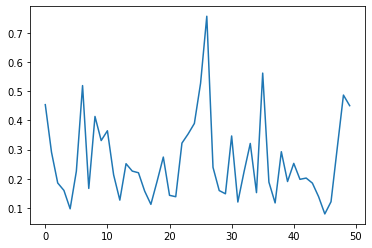

In [9]:



maxThres = 0;

# for i in range(len(mses)):
#     #print()
# #     scaler = MinMaxScaler(feature_range=(0, 1))
# #     mses[i] = scaler.fit_transform(mses[i])
#     mses[i] = sigmoid(mses[i])
# for i in range(len(msesTrain)):
#     print()
#     #scaler = MinMaxScaler(feature_range=(0, 1))
#     #msesTrain[i] = scaler.fit_transform(msesTrain[i])
#     msesTrain[i] = sigmoid(msesTrain[i])


plt.plot(mses[0][0:50])
#print(msesTrain[2])

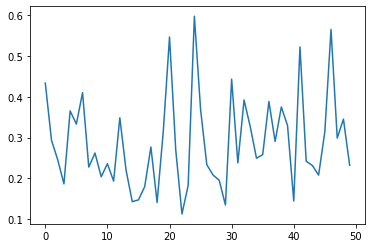

In [10]:
plt.plot(msesTrain[0][0:50])

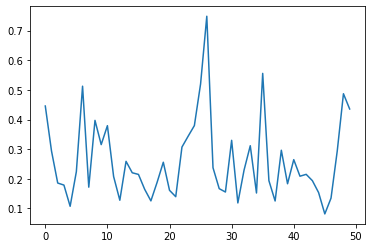

In [11]:
plt.plot(mses[2][0:50])

[0.56566654]
[0.58868682]
[0.55702115]
[0.58845079]
[0.56588737]
[0.55989517]


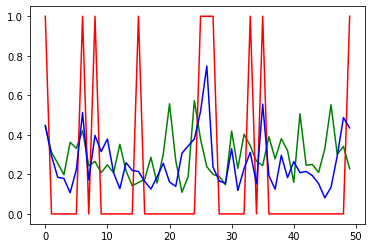

In [12]:
plt.plot(msesTrain[2][0:50],color="green")
plt.plot(y_test[0:50],color="red")
plt.plot(mses[2][0:50],color="blue")
threshez = []
for i in range(len(msesTrain)):
    #print(msesTrain[i][msesTrain[i]>0.8])
    #print((msesTrain[0].shape[0])*0.02)
    #print(msesTrain[1].shape)
    print(-np.sort(-msesTrain[i],axis =0)[math.ceil((msesTrain[0].shape[0])*percentChosen)])
    threshez.append(-np.sort(-msesTrain[i],axis =0)[math.ceil((msesTrain[0].shape[0])*percentChosen)][0])
#print(threshez)

<Figure size 432x288 with 0 Axes>

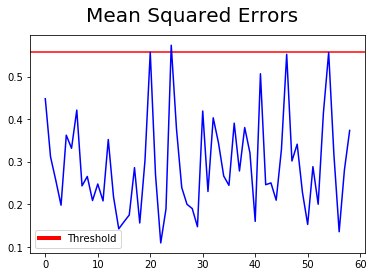

In [13]:
#plt.axhline(y=msesTrain[2],color="green")
import matplotlib.transforms as transforms
from matplotlib.lines import Line2D
fig= plt.figure()
fig2, ax = plt.subplots()
custom_lines = [Line2D([0], [0], color='r', lw=4)]
ax.legend(custom_lines, ['Threshold'])
fig2.suptitle('Mean Squared Errors', fontsize=20)

# plt.xlabel('xlabel', fontsize=18)
# plt.ylabel('ylabel', fontsize=16)
plt.axhline(y=(threshez[2]), color='r', linestyle='-')
plt.plot(msesTrain[2],color="blue")


0.925
0.94
0.9233333333333333
0.88
0.8916666666666666
0.9216666666666667
0.92


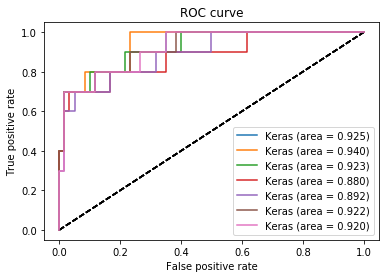

In [14]:
for i in range(len(mses)):
        
        fpr_keras3, tpr_keras3, thresholds_keras3 = roc_curve(y_test, mses[i])
        auc_keras3 = auc(fpr_keras3, tpr_keras3)
        #aucs.append(auc_keras3)
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')

        plt.plot(fpr_keras3, tpr_keras3, label='Keras (area = {:.3f})'.format(auc_keras3))
        print(auc_keras3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()    

In [15]:
votes = [];
threshes = [];
#pd.set_option("display.max_rows", None, "display.max_columns", None)
#print(y_test)
for i in range(len(mses)):
    threshes.append(Find_Optimal_Cutoff(y_test,mses[i]))
#print(mses[0])
for i in range(len(threshes)):
    temp = mses[i]
    tempvotes = []
    for j in range(len(y_test)):
        if(temp[j]>threshes[i]):
            tempvotes.append(1)
        else:
            tempvotes.append(0)
    votes.append(tempvotes)
votes = np.array(votes)
#print([pd.DataFrame(votes[0]),y_test])
#print(pd.concat([pd.DataFrame(votes[0]), y_test], axis=1))


y_test_list = y_test.values.tolist()
for j in range(len(threshes)):    
    sumss = 0;
    for i in range(len(y_test_list)):
        if(votes[j][i]==y_test_list[i][0]):
            sumss = sumss+1
        #print(str(vote_result[i])+'\t '+ str(y_test_list[i]))  
    print(j)
    print(sumss/len(y_test_list))



0
0.7857142857142857
1
0.7857142857142857
2
0.8
3
0.8142857142857143
4
0.8142857142857143
5
0.7857142857142857
6
0.7571428571428571


0
0.8714285714285714
1
0.8714285714285714
2
0.8714285714285714
3
0.8714285714285714
4
0.8714285714285714
5
0.8714285714285714
-0.3272747787926342
-0.35315009750623455
-0.31864475214569626
-0.3471727992271397
-0.3291738316616405
-0.32183588587697276
values
mean_of_means
-0.332875357535053
-0.3272747787926342
-0.35315009750623455
-0.31864475214569626
-0.3471727992271397
-0.3291738316616405
-0.32183588587697276
values


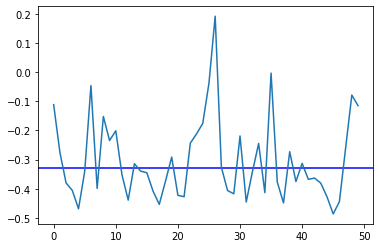

In [16]:
#pare tin apostasi apo to thresh ws determining factor :)

votes = [];
votes_negative = [];

#pd.set_option("display.max_rows", None, "display.max_columns", None)
#print(y_test)
#print(mses[0])
for i in range(len(threshez)):
    temp = mses[i]
    tempvotes = []
    tempvotes_negative = [];
    #print("thresh",threshez[i])
    for j in range(len(y_test)):
        #new thresh
#       if(temp[j]-threshez[i]>0):
#             if(abs(temp[j]-threshez[i]>0.001)):
#                 tempvotes.append(1)
#                 tempvotes_negative.append(1)
#             else:
#                 tempvotes.append(0)
#                 tempvotes_negative.append(-1)
        #old thresh
        #print(mses[i][j])
        if(mses[i][j]>threshez[i] ):
            tempvotes.append(1)
            tempvotes_negative.append(1)
#         else:
#                 tempvotes.append(0)
        else:
            tempvotes.append(0)
            tempvotes_negative.append(-1)
    votes.append(tempvotes)
    votes_negative.append(tempvotes_negative)
votes = np.array(votes)
votes_negative = np.array(votes_negative)
#print([pd.DataFrame(votes[0]),y_test])
#print(pd.concat([pd.DataFrame(votes[0]), y_test], axis=1))


#y_test_list = y_test.values.tolist()
for j in range(len(threshez)):    
    sumss = 0;
    for i in range(len(y_test_list)):
        if(votes[j][i]==y_test_list[i][0]):
            sumss = sumss+1
    print(j)
    print(sumss/len(y_test_list))
    
    
distances_from_thresh = []
for i in range(len(threshez)):
    temp = mses[i]
    tempdistances = []
    for j in range(len(y_test_list)):
        tempdistances.append(mses[i][j][0]-threshez[i])
        #print(mses[i][j][0]-threshez[i])
    distances_from_thresh.append(tempdistances)
#print(distances_from_thresh)
distances_from_thresh = np.array(distances_from_thresh)
#distances_from_thresh = sigmoid(distances_from_thresh)
# for i in range(len(distances_from_thresh)):
#     distances_from_thresh[i] = (distances_from_thresh[i] - np.min(distances_from_thresh[i])/np.ptp(distances_from_thresh[i]))

# distances_from_thresh[0] = distances_from_thresh[0] - distances_from_thresh[0].mean()
# distances_from_thresh[1] = distances_from_thresh[1] - distances_from_thresh[1].mean()
# distances_from_thresh[2] = distances_from_thresh[2] - distances_from_thresh[2].mean()
# distances_from_thresh[3] = distances_from_thresh[3] - distances_from_thresh[3].mean()
# distances_from_thresh[4] = distances_from_thresh[4] - distances_from_thresh[4].mean()
# distances_from_thresh[5] = distances_from_thresh[5] - distances_from_thresh[5].mean()
#scaler = MinMaxScaler(feature_range=(0, 1))
#distances_from_thresh = scaler.fit_transform(np.array(distances_from_thresh))
#print(distances_from_thresh[0])
#print(distances_from_thresh[0])
#plt.plot(distances_from_thresh[0][0:100])
#plt.plot(y_test[0:20])
print(distances_from_thresh[0].mean())
distance_from_thresh_0 = distances_from_thresh[0].mean()
print(distances_from_thresh[1].mean())
distance_from_thresh_1 = distances_from_thresh[1].mean()
print(distances_from_thresh[2].mean())
distance_from_thresh_2 = distances_from_thresh[2].mean()
print(distances_from_thresh[3].mean())
distance_from_thresh_3 = distances_from_thresh[3].mean()
print(distances_from_thresh[4].mean())
distance_from_thresh_4 = distances_from_thresh[4].mean()
print(distances_from_thresh[5].mean())
distance_from_thresh_5 = distances_from_thresh[5].mean()
print("values")
mean_of_means = np.mean([distances_from_thresh[0].mean(),distances_from_thresh[1].mean(),distances_from_thresh[2].mean(),distances_from_thresh[3].mean(),distances_from_thresh[4].mean(),distances_from_thresh[5].mean()])
print("mean_of_means")
print(mean_of_means)

# print(distances_from_thresh[0][20])
# print(distances_from_thresh[1][20])
# print(distances_from_thresh[2][20])
# print(distances_from_thresh[3][20])
# print(distances_from_thresh[4][20])
# print(distances_from_thresh[5][20])


#plt.plot(distances_from_thresh[1],color="red")
#plt.plot(distances_from_thresh[0])
plt.axhline(y=(distance_from_thresh_0), color='b', linestyle='-')
plt.plot(distances_from_thresh[0][0:50])
pre = distances_from_thresh[2]
#plt.plot(distances_from_thresh[3])
#plt.plot(distances_from_thresh[4])
#plt.plot(distances_from_thresh[5])

#distances_from_thresh = sigmoid(distances_from_thresh)
#distances_from_thresh = np.tanh(distances_from_thresh)
# for i in range(len(distances_from_thresh)):
#     distances_from_thresh[i] = (distances_from_thresh[i] - np.min(distances_from_thresh[i])/np.ptp(distances_from_thresh[i]))
#scaler = MinMaxScaler(feature_range=(0, 1))
#distances_from_thresh = scaler.fit_transform(np.array(distances_from_thresh))
#print(distances_from_thresh[0])
#print(distances_from_thresh[0])
#plt.plot(distances_from_thresh[0][0:100])
#plt.plot(y_test[0:20])
print(distances_from_thresh[0].mean())
print(distances_from_thresh[1].mean())
print(distances_from_thresh[2].mean())
print(distances_from_thresh[3].mean())
print(distances_from_thresh[4].mean())
print(distances_from_thresh[5].mean())

print("values")
# print(distances_from_thresh[0][20])
# print(distances_from_thresh[1][20])
# print(distances_from_thresh[2][20])
# print(distances_from_thresh[3][20])
# print(distances_from_thresh[4][20])
# print(distances_from_thresh[5][20])
#print(max(distances_from_thresh[5]))
#plt.plot(distances_from_thresh[0])
#plt.plot(distances_from_thresh[2])

#plt.plot(distances_from_thresh[3])
#plt.plot(distances_from_thresh[4])
#plt.plot(distances_from_thresh[5])
#print(distances_from_thresh[1])

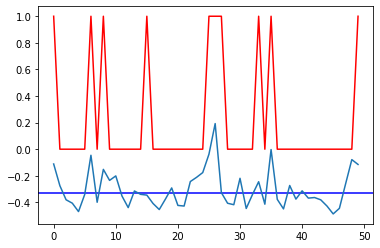

In [17]:
plt.axhline(y=(distances_from_thresh[0].mean()), color='b', linestyle='-')
plt.plot((distances_from_thresh[0][0:50]))
plt.plot(y_test[0:50],color = "r")

0.8929413147348055


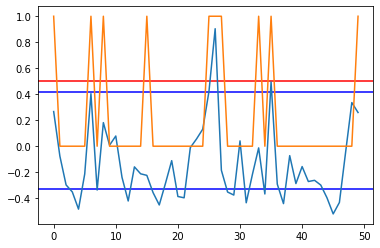

In [18]:
#pithanotites
distances_from_thres=[]


distances_from_thres.append(distance_from_thresh_0)
distances_from_thres.append(distance_from_thresh_1)
distances_from_thres.append(distance_from_thresh_2)
distances_from_thres.append(distance_from_thresh_3)
distances_from_thres.append(distance_from_thresh_4)
distances_from_thres.append(distance_from_thresh_5)

# distances_from_thres.append(sigmoid(distance_from_thresh_0))
# distances_from_thres.append(sigmoid(distance_from_thresh_1))
# distances_from_thres.append(sigmoid(distance_from_thresh_2))
# distances_from_thres.append(sigmoid(distance_from_thresh_3))
# distances_from_thres.append(sigmoid(distance_from_thresh_4))
# distances_from_thres.append(sigmoid(distance_from_thresh_5))

ps = []
test = [];
test2 = [];
for i in range(len(threshez)):
    
    tempP=[]
    for j in range(len(y_test)):
        if(i==0):
            test.append(((mses[i][j]-threshez[i]))/(threshez[i]-math.sqrt(distances_from_thres[i]**2)))
        if(mses[i][j]>=(threshez[i]) ):
            if(i==0):
                test2.append(1)
            
            #tempP.append(abs(distances_from_thresh[i].mean())+0.5+(0.5*((mses[i][j]-threshez[i]))/(threshez[i]-(distances_from_thres[i]))))
            #print("all values over thresh")
            #print("mse",mses[i][j])
            #print("thres",threshez[i])
            #print("mean",distances_from_thres[i])
            if(distances_from_thres[i]<0):
                tempP.append(0.5
                             #+abs(math.sqrt()distances_from_thres[i] ** 2)
                             +((0.5)*((mses[i][j]-threshez[i]))/(threshez[i]-math.sqrt(distances_from_thres[i]** 2))))
            else:
                tempP.append(0.5+((0.5)*((mses[i][j]-threshez[i]))/(threshez[i]-math.sqrt(distances_from_thres[i]** 2))))

        else:
            if(i==0):
                test2.append(0)
            #print("all values below thresh")
            #print("mse",mses[i][j])
            #print("thres",threshez[i])
            #print("mean",distances_from_thres[i])
            if(distances_from_thres[i]<0):
                tempP.append(((0.5)*((mses[i][j]-math.sqrt(distances_from_thres[i]**2)))/(threshez[i]-math.sqrt(distances_from_thres[i]**2))))
            else:
                tempP.append(((0.5)*((mses[i][j]-math.sqrt(distances_from_thres[i]**2)))/(threshez[i]-math.sqrt(distances_from_thres[i]**2))))
            
    ps.append(tempP)     
plt.axhline(y=0.5, color='r', linestyle='-')
plt.axhline(y=sigmoid(distance_from_thresh_0), color='b', linestyle='-')
plt.axhline(y=(distance_from_thresh_0), color='b', linestyle='-')
print(threshez[0]-distances_from_thres[0].mean())
# for i in range(len(ps)):
#     ps[i] = (ps[i] - np.min(ps[i])/np.ptp(ps[i]))

plt.plot(ps[0][0:50])
plt.plot(y_test[0:50])


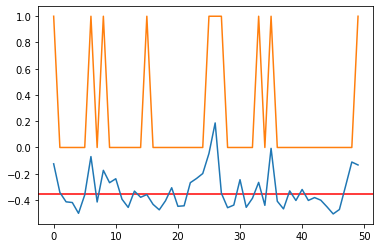

In [19]:
plt.axhline(y=distance_from_thresh_1, color='r', linestyle='-')
plt.plot(distances_from_thresh[1][0:50])
plt.plot(y_test[0:50])

[0.5656665359421713, 0.5886868184510715, 0.5570211520392424, 0.588450794913945, 0.5658873699394497, 0.5598951682674798]


<BarContainer object of 6 artists>

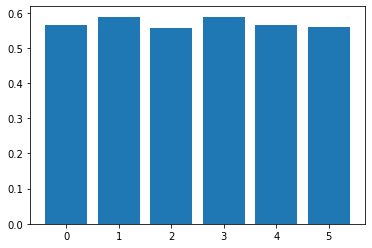

In [20]:
print(threshez)
plt.bar(range(len(threshez)),threshez)

-0.2194456300063779


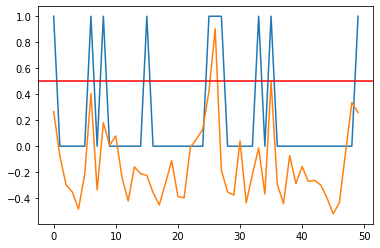

In [21]:
print(np.array(ps[3]).mean())
#print(ps[3].shape)

#print(np.array(ps[3]))
sss = np.array(ps[3])
# for i in range(len(ps[3])):
#     sss[i] = sigmoid(sss[i][0])
# plt.plot(sss)
plt.plot(y_test[0:50])
plt.plot(ps[0][0:50])
plt.axhline(y=0.5, color='r', linestyle='-')


In [22]:
threshez[1]

0.5886868184510715

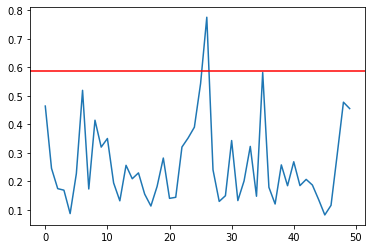

In [23]:
plt.plot(mses[1][0:50])
plt.axhline(y=threshez[1], color='r', linestyle='-')

In [24]:
distances_from_thres[0]

-0.3272747787926342

In [25]:
# import sys
# np.set_printoptions(threshold=sys.maxsize)
# #np.column_stack((votes[0], votes[1],votes[2],votes[3],votes[4],votes[5],vote_result,vote_result_negative,vote_result_distance,vote_result_distance_temp,y_test_list))
np.column_stack((y_test,test,test2))

array([[ 1.        , -0.46667864,  0.        ],
       [ 0.        , -1.1524862 ,  0.        ],
       [ 0.        , -1.59592613,  0.        ],
       [ 0.        , -1.70336146,  0.        ],
       [ 0.        , -1.96825222,  0.        ],
       [ 0.        , -1.42707678,  0.        ],
       [ 1.        , -0.19174716,  0.        ],
       [ 0.        , -1.67438762,  0.        ],
       [ 1.        , -0.63694651,  0.        ],
       [ 0.        , -0.98415858,  0.        ],
       [ 0.        , -0.84301902,  0.        ],
       [ 0.        , -1.47840633,  0.        ],
       [ 0.        , -1.84291752,  0.        ],
       [ 0.        , -1.31815084,  0.        ],
       [ 0.        , -1.4246384 ,  0.        ],
       [ 1.        , -1.44864495,  0.        ],
       [ 0.        , -1.71347407,  0.        ],
       [ 0.        , -1.90409758,  0.        ],
       [ 0.        , -1.57156424,  0.        ],
       [ 0.        , -1.22237249,  0.        ],
       [ 0.        , -1.77393253,  0.   

In [26]:
len(distances_from_thresh[1])


70

In [27]:
for i in range(len(votes)):
    fpsum = 0;
    fnsum = 0;
    performanceSum = 0;
    for j in range(len(votes[i])):
        if(votes[i][j] == y_test_list[j][0]):
            performanceSum = performanceSum + 1;
        elif((votes[i][j] == 1) & (y_test_list[j][0]==0)):
            fnsum = fnsum + 1;
        elif((votes[i][j] == 0) & (y_test_list[j][0]==1)):
            fpsum = fpsum + 1;
            
    print("network ",i)
    print("performance ",performanceSum/len(y_test));
    print("false positive ",fpsum/len(y_test));
    print("false negative ",fnsum/len(y_test))


network  0
performance  0.8714285714285714
false positive  0.12857142857142856
false negative  0.0
network  1
performance  0.8714285714285714
false positive  0.12857142857142856
false negative  0.0
network  2
performance  0.8714285714285714
false positive  0.12857142857142856
false negative  0.0
network  3
performance  0.8714285714285714
false positive  0.12857142857142856
false negative  0.0
network  4
performance  0.8714285714285714
false positive  0.12857142857142856
false negative  0.0
network  5
performance  0.8714285714285714
false positive  0.12857142857142856
false negative  0.0


In [28]:
vote_result = []
vote_result_negative = []
vote_result_distance = []
vote_result_distance_temp = []
vote_result_distance_temp2 = []
vote_result_distance_p = []
for i in range(len(y_test_list)):
#     print(
#     (0
#         +votes[0][i]
#         +votes[1][i]
#         +votes[2][i]
#         +votes[3][i]
#         +votes[4][i]
#         +votes[5][i]
#     )/2)
    if((0
        +1*votes[0][i]
        +1*votes[1][i]
        +1*votes[2][i]
        +1*votes[3][i]
        +1*votes[4][i]
        +1*votes[5][i]
        #+votes[6][i]
        )/6>=0.5):
        vote_result.append(1)
    else:
        vote_result.append(0)
        
        
      
    if(votes_negative[0][i]==1):
        votes_negative[0][i] = 1*votes_negative[0][i]
    else:
        votes_negative[0][i] = 1*votes_negative[0][i]
     
    if(votes_negative[1][i]==1):
        votes_negative[1][i] = 1*votes_negative[1][i]
    else:
        votes_negative[1][i] = 1*votes_negative[1][i]
        
    if(votes_negative[2][i]==1):
        votes_negative[2][i] = 1*votes_negative[2][i]
    else:
        votes_negative[2][i] = 1*votes_negative[2][i]
        
    if(votes_negative[3][i]==1):
        votes_negative[3][i] = 1*votes_negative[3][i]
    else:
        votes_negative[3][i] = 1*votes_negative[3][i]
        
    if(votes_negative[4][i]==1):
        votes_negative[4][i] = 1*votes_negative[4][i]
    else:
        votes_negative[4][i] = 1*votes_negative[4][i]
        
    if(votes_negative[5][i]==1):
        votes_negative[5][i] = 1*votes_negative[5][i]
    else:
        votes_negative[5][i] = 1*votes_negative[5][i]

    temp_distance2 = 0;
    if(distances_from_thresh[0][i]>distance_from_thresh_0):
        temp_distance2 = temp_distance2 +1;
    else:
        temp_distance2 = temp_distance2 -1;
        
    if(distances_from_thresh[1][i]>distance_from_thresh_1):
        temp_distance2 = temp_distance2 +1;
    else:
        temp_distance2 = temp_distance2 -1;
    
    if(distances_from_thresh[2][i]>distance_from_thresh_2):
        temp_distance2 = temp_distance2 +1;
    else:
        temp_distance2 = temp_distance2 -1;
    if(distances_from_thresh[3][i]>distance_from_thresh_3):
        temp_distance2 = temp_distance2 +1;
    else:
        temp_distance2 = temp_distance2 -1;
    if(distances_from_thresh[4][i]>distance_from_thresh_4):
        temp_distance2 = temp_distance2 +1;
    else:
        temp_distance2 = temp_distance2 -1;
    if(distances_from_thresh[5][i]>distance_from_thresh_5):
        temp_distance2 = temp_distance2 +1;
    else:
        temp_distance2 = temp_distance2 -1;
        
    temp_distance =  (distances_from_thresh[0][i]+distances_from_thresh[1][i]+distances_from_thresh[2][i]+distances_from_thresh[3][i]+distances_from_thresh[4][i]+distances_from_thresh[5][i])/6
    temp = votes_negative[0][i]+votes_negative[1][i]+votes_negative[2][i]+votes_negative[3][i]+votes_negative[4][i]+votes_negative[5][i]
    #+1*votes_negative[6]
    temp2 = votes_negative[0][i],votes_negative[1][i],votes_negative[2][i],votes_negative[3][i],votes_negative[4][i],votes_negative[5][i]
    #print(all(elem == temp2[0] for elem in temp2))
    temp_distance_p =  (ps[0][i]+ps[1][i]+ps[2][i]+ps[3][i]+ps[4][i]+ps[5][i])/6
    
    if(temp>=0):
#         if(not(all(elem > 0 for elem in temp2))):
#             if(y_test_list[i][0]==0):
#                 print("temp",temp)
#                 print(votes_negative[0][i])
#                 print(votes_negative[1][i])
#                 print(votes_negative[2][i])
#                 print(votes_negative[3][i])
#                 print(votes_negative[4][i])
#                 print(votes_negative[5][i])
#                 print("actual",y_test[0][i])
        vote_result_negative.append(1)
    else:
        vote_result_negative.append(0)
#         if(not(all(elem < 0 for elem in temp2))):
#             if(y_test_list[i][0]==1):
#                 print("temp",temp)
#                 print(votes_negative[0][i])
#                 print(votes_negative[1][i])
#                 print(votes_negative[2][i])
#                 print(votes_negative[3][i])
#                 print(votes_negative[4][i])
#                 print(votes_negative[5][i])
#                 print("actual",y_test[0][i])
    vote_result_distance_temp.append(temp_distance)
    if(temp_distance>0.5):
        vote_result_distance.append(1)
    else:
        vote_result_distance.append(0)
       
    if(temp_distance2>=0):
        vote_result_distance_temp2.append(1)
    else:
        vote_result_distance_temp2.append(0)
    if(temp_distance_p>=0.5):
        vote_result_distance_p.append(1)
    else:
        vote_result_distance_p.append(0)
    
fpsum = 0;
fnsum = 0;
performanceSum = 0;
performanceSumNegative = 0;
performanceSumDistance = 0;
performanceSumDistance2 = 0;
performanceSumDistanceP = 0;
for j in range(len(votes[0])):
    
    if(vote_result[j] == y_test_list[j][0]):
        performanceSum = performanceSum + 1;
    elif((vote_result[j] == 1) & (y_test_list[j][0]==0)):
        fnsum = fnsum + 1;
    elif((vote_result[j] == 0) & (y_test_list[j][0]==1)):
        fpsum = fpsum + 1;
    
    if(vote_result_negative[j] == y_test_list[j][0]):
        performanceSumNegative = performanceSumNegative + 1;
    if(vote_result_distance[j] == y_test_list[j][0]):
        performanceSumDistance = performanceSumDistance + 1;
    if(vote_result_distance_temp2[j] == y_test_list[j][0]):
        performanceSumDistance2 = performanceSumDistance2 + 1;   
    if(vote_result_distance_p[j] == y_test_list[j][0]):
        performanceSumDistanceP = performanceSumDistanceP + 1;    
        
        
print("network vote_result")
print("performance ",performanceSum/len(y_test));
print("false positive ",fpsum/len(y_test));
print("false negative ",fnsum/len(y_test))
print("performance Negative ",performanceSumNegative/len(y_test));
print("performance Distance ",performanceSumDistance/len(y_test));
print("performance Distance2 ",performanceSumDistance2/len(y_test));
print("performance DistanceP ",performanceSumDistanceP/len(y_test));

network vote_result
performance  0.8714285714285714
false positive  0.12857142857142856
false negative  0.0
performance Negative  0.8714285714285714
performance Distance  0.8571428571428571
performance Distance2  0.7714285714285715
performance DistanceP  0.8714285714285714


In [29]:
#print(votes[0])

In [30]:
import sys
np.set_printoptions(threshold=sys.maxsize)
#np.column_stack((votes[0], votes[1],votes[2],votes[3],votes[4],votes[5],vote_result,vote_result_negative,vote_result_distance,vote_result_distance_temp,y_test_list))
np.column_stack((vote_result_distance_p,vote_result_distance_temp2,vote_result,y_test_list))

array([[0., 1., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 1.],
       [0., 0., 0., 0.],
       [0., 1., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 1.],
       [1., 1., 1., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 1.],
       [0., 0., 0., 0.],
       [0., 1., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],


In [31]:
#vale ta benchmark datasets :)

In [32]:
tf.keras.backend.clear_session()


In [33]:
wrongPositives = 0;
print("vote_result ");
for j in range(len(vote_result)):
    if((vote_result[j]==1) & (y_test_list[j][0]==0)):
        wrongPositives = wrongPositives+1;
print(wrongPositives)

for i in range(len(votes)):
    print("model ",i);
    wrongPositives = 0;
    for j in range(len(votes[i])):
        if((votes[i][j]==1) & (y_test_list[j][0]==0)):
            wrongPositives = wrongPositives+1;
    print(wrongPositives)
    
for i in range(len(votes)):
    print("model ",i);
    wrongPositives = 0;
    for j in range(len(votes[i])):
        if((votes[i][j]==0) & (y_test_list[j][0]==1)):
            wrongPositives = wrongPositives+1;
    print(wrongPositives)

vote_result 
0
model  0
0
model  1
0
model  2
0
model  3
0
model  4
0
model  5
0
model  0
9
model  1
9
model  2
9
model  3
9
model  4
9
model  5
9


In [34]:
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.ensemble import VotingClassifier

# estimators = []

# keras_model = KerasClassifier(build_fn=models[0], epochs=150, batch_size=256, verbose=0)    # create model
# keras_model2 = KerasClassifier(build_fn=models[1], epochs=150, batch_size=256, verbose=0)    # create model
# keras_model3 = KerasClassifier(build_fn=models[2], epochs=150, batch_size=256, verbose=0)    # create model

# clf = [("DNN1", keras_model),("DNN2", keras_model2), ('DNN3', keras_model3)]
# #ensemble = VotingClassifier(estimators)    # create the ensemble model

# ensemble = VotingClassifier(estimators=clf)
# #eclf = VotingClassifier(clf, weights=[1.0,1.0])
# ensemble.fit(X_train,X_train)
# y_hat = ensemble.predict(X_test)

# #result = keras_model.score(X_test, y_test)


In [35]:
# from scipy.optimize import minimize
# from scipy.optimize import basinhopping
# def getMax(array):
#     votes_negative = [];
#     for i in range(len(threshez)):
#         temp = mses[i]
#         tempvotes_negative = [];
#         #print("thresh",threshez[i])
#         for j in range(len(y_test)):
#             #new thresh
#     #       if(temp[j]-threshez[i]>0):
#     #             if(abs(temp[j]-threshez[i]>0.001)):
#     #                 tempvotes.append(1)
#     #                 tempvotes_negative.append(1)
#     #             else:
#     #                 tempvotes.append(0)
#     #                 tempvotes_negative.append(-1)
#             #old thresh
#             #print(mses[i][j])
#             if(mses[i][j]>threshez[i] ):
#                 tempvotes_negative.append(1)
#     #         else:
#     #                 tempvotes.append(0)
#             else:
#                 tempvotes_negative.append(-1)
#         votes_negative.append(tempvotes_negative)
#     votes_negative = np.array(votes_negative)
#     vote_result_negative = []
#     for i in range(len(y_test_list)):

#         if(votes_negative[0][i]==1):
#             votes_negative[0][i] = array[0]*votes_negative[0][i]
#         else:
#             votes_negative[0][i] = array[1]*votes_negative[0][i]

#         if(votes_negative[1][i]==1):
#             votes_negative[1][i] = array[2]*votes_negative[1][i]
#         else:
#             votes_negative[1][i] = array[3]*votes_negative[1][i]

#         if(votes_negative[2][i]==1):
#             votes_negative[2][i] = array[4]*votes_negative[2][i]
#         else:
#             votes_negative[2][i] = array[5]*votes_negative[2][i]

#         if(votes_negative[3][i]==1):
#             votes_negative[3][i] = array[6]*votes_negative[3][i]
#         else:
#             votes_negative[3][i] = array[7]*votes_negative[3][i]

#         if(votes_negative[4][i]==1):
#             votes_negative[4][i] = array[8]*votes_negative[4][i]
#         else:
#             votes_negative[4][i] = array[9]*votes_negative[4][i]

#         if(votes_negative[5][i]==1):
#             votes_negative[5][i] = array[10]*votes_negative[5][i]
#         else:
#             votes_negative[5][i] = array[11]*votes_negative[5][i]


#         temp = votes_negative[0][i]+votes_negative[1][i]+votes_negative[2][i]+votes_negative[3][i]+votes_negative[4][i]+votes_negative[5][i]
#         #+1*votes_negative[6]
#         temp2 = votes_negative[0][i],votes_negative[1][i],votes_negative[2][i],votes_negative[3][i],votes_negative[4][i],votes_negative[5][i]
#         #print(all(elem == temp2[0] for elem in temp2))
#         if(temp>=0):
#             vote_result_negative.append(1)
#         else:
#             vote_result_negative.append(0)

#     performanceSumNegative = 0;
#     for j in range(len(votes[0])):
#         if(vote_result_negative[j] == y_test_list[j][0]):
#             performanceSumNegative = performanceSumNegative + 1;

#     return -(performanceSumNegative/len(y_test))


# # bounds = ((0, 10), (0, 10),(0, 10),(0, 10),(0, 10),(0, 10),(0, 10),(0, 10),(0, 10),(0, 10),(0, 10),(0, 10),)
# # res = minimize(

# #     getMax,

# #     x0=[1,1,1,1,1,1,1,1,1,1,1,1],

# # #     constraints=constraint,

# #      bounds=bounds,

# # )

# res2 = basinhopping(
#     getMax,
#     x0=[1,1,1,1,1,1,1,1,1,1,1,1],
#     #niter = 100
# )

In [36]:

# print("first params")
# print(res2.x[0:2])
# print("second params")
# print(res2.x[2:4])
# print("third params")
# print(res2.x[4:6])
# print("fourth params")
# print(res2.x[6:8])
# print("fifth params")
# print(res2.x[8:10])
# print("sixth params")
# print(res2.x[10:12])
# print(res2)
# print(res2.fun)